# Quickstart Guide

### Imports

In [33]:
import pm4py
import utils.extractor as extractor
import utils.frames as frames
import math
import visualization.viz as viz
from simulation.simulator import Simulator
from simulation.objects.enums import Callbacks, SimulationModes, TimestampModes, OptimizationModes, SchedulingBehaviour
import utils.fairness as Fairness
import utils.congestion as Congestion
import utils.optimization as Optimization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from temp.WorkDistribution import GetActivityResourceMapping
from utils.activityDuration import EventDurationsByMinPossibleTime

### Parameters

In [34]:
originalLogPath  = 'logs/log_ResReduced.xes'
simulatedLogPath = 'logs/jupyterQuickstart_log_ResReduced.xes'

FAIRNESS_BACKLOG_N   = 5000
CONGESTION_BACKLOG_N = 50

simulationMode      = SimulationModes.KNOWN_FUTURE #PREDICTED_FUTURE
optimizationMode    = OptimizationModes.FAIRNESS   #CONGESTION, BOTH 
schedulingBehaviour = SchedulingBehaviour.CLEAR_ASSIGNMENTS_EACH_WINDOW #KEEP_ASSIGNMENTS

### Callbacks for the MIP-Scheduling

In [35]:
def SimulatorFairness_Callback(simulatorState):
    #return Fairness.FairnessBacklogFair_TIME(simulatorState, BACKLOG_N=FAIRNESS_BACKLOG_N)
    return Fairness.FairnessBacklogFair_WORK(simulatorState, BACKLOG_N=FAIRNESS_BACKLOG_N)

In [36]:
def SimulatorCongestion_Callback(simulatorState):
    #segmentFreq, segmentTime, waitingTraces = Congestion.GetActiveSegments(activeTraces, simTime, SimulationModes.KNOWN_FUTURE)
    #return Congestion.GetProgressByWaitingNumberInFrontOfActivity(A, segmentFreq, waitingTraces)
    return {}

In [37]:
def SimulatorWindowStartScheduling_Callback(simulatorState, schedulingReadyResources, fRatio, cRatio):
    return Optimization.OptimizeActiveTraces(simulatorState, schedulingReadyResources, fRatio, cRatio)

### Simulator Setup

In [38]:
originalLog = pm4py.read_xes(originalLogPath)

windowNumber = 100 * math.ceil(math.sqrt(sum([len(trace) for trace in originalLog])))

# Convert XES-Events into dict {'act', 'ts', 'res', 'single', 'cid'}
event_dict = extractor.event_dict(originalLog, res_info=True)

windowWidth = frames.get_width_from_number(event_dict, windowNumber)
bucketId_borders_dict = frames.bucket_window_dict_by_width(event_dict, windowWidth)
eventsPerWindowDict, id_frame_mapping = frames.bucket_id_list_dict_by_width(event_dict, windowWidth) # WindowID: [List of EventIDs] , EventID: WindowID       

parsing log, completed traces :: 100%|██████████| 7619/7619 [00:01<00:00, 5141.16it/s]


In [39]:
sim = Simulator(event_dict, eventsPerWindowDict, bucketId_borders_dict, 
        simulationMode=simulationMode, optimizationMode=optimizationMode,schedulingBehaviour =schedulingBehaviour,
        endTimestampAttribute='ts', verbose=False)
    
sim.Register(Callbacks.WND_START_SCHEDULING, SimulatorWindowStartScheduling_Callback)
sim.Register(Callbacks.CALC_Fairness,        SimulatorFairness_Callback)
sim.Register(Callbacks.CALC_Congestion,      SimulatorCongestion_Callback)
sim.Register(Callbacks.CALC_EventDurations,  lambda x,y: EventDurationsByMinPossibleTime(x,y))

In [40]:
# Run the simulation
sim.Run()
sim.ExportSimulationLog(simulatedLogPath)

Progress: 99.95% complete - Traces (Active / Finished / Total):    1 / 7615 / 7619

Total time for simulation 128.0s
    -> Windows simulated 24486 (given: 24487 / additional: -1)


exporting log, completed traces :: 100%|██████████| 7619/7619 [00:00<00:00, 10274.53it/s]


### Result

parsing log, completed traces :: 100%|██████████| 7619/7619 [00:01<00:00, 6956.63it/s] 


<Figure size 3500x6000 with 0 Axes>

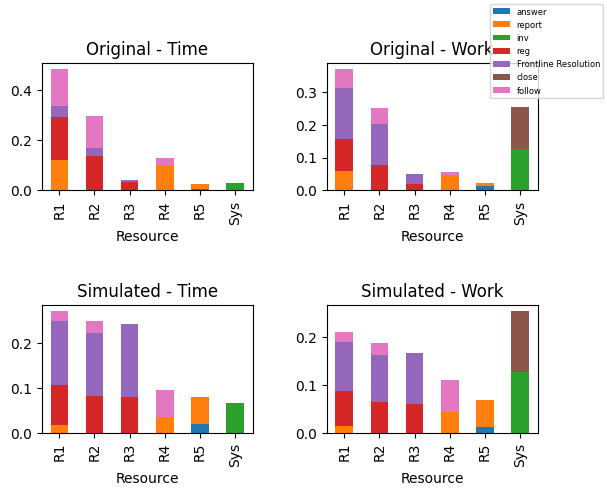

In [41]:
simulatedLog = pm4py.read_xes(simulatedLogPath)

dfOriginal, dfO2  = GetActivityResourceMapping(originalLog)
dfSimulated, dfS2 = GetActivityResourceMapping(simulatedLog)


def GetValue(df, r, a, col):
    val = df.loc[(df.Resource == r) & (df.Activity == a)][col]
    if len(val) == 0:
        return 0
    else:    
        return val.values[0]
    
# plot with various axes scales - https://matplotlib.org/3.1.1/gallery/pyplots/pyplot_scales.html#sphx-glr-gallery-pyplots-pyplot-scales-py
plt.figure(figsize=(35,60))
fig, axes = plt.subplots(2, 2)

def PlotChart(title, df, col, plotX, plotY):
    A = sorted(list(set(df['Activity'])))
    R = sorted(list(set(df['Resource'])))
            
    df = pd.DataFrame([[str(r)[0:3]] + [GetValue(df, r, a, col) for a in A] for r in R], columns=['Resource'] + A)
    
    # plot data in stack manner of bar type
    df.plot(x='Resource', kind='bar', stacked=True, title=title, ax=axes[plotX, plotY], legend=False)
    plt.title(title)
    plt.grid(False)

PlotChart('Original - Time', dfO2, 'Relative-Time', 0, 0)
PlotChart('Original - Work', dfO2, 'Relative-Activities', 0, 1)

PlotChart('Simulated - Time', dfS2, 'Relative-Time', 1, 0)
PlotChart('Simulated - Work', dfS2, 'Relative-Activities', 1, 1)

fig.legend(list(set(dfO2['Activity'])), prop={'size': 6})

# Set padding between subplots
plt.subplots_adjust(hspace=0.90, wspace=0.35)
plt.show()